In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [3]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 150800548.58it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 8727984.28it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37786181.26it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18955750.02it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data,**kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [5]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),  #28x28x3 28x28x8
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, padding=1),  #28x28x8 28x28x16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  #28x28x16 28x28x32
            nn.ReLU(),
            nn.BatchNorm2d(32),      
            nn.MaxPool2d(2, 2), #28x28x32 14x14x32           
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1, padding=0),  #14x14x32 12x12x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 10, 1, stride=1, padding=0),  #12x12x32 12x12x10
            nn.ReLU(),
            nn.BatchNorm2d(10),
            )
        self.pool = nn.AdaptiveAvgPool2d((1,1)) # 1x1x10 
        

    def forward(self, x):
        x = self.conv1(x)  
        x = self.conv2(x)
        x = self.pool(x)
        x = x.squeeze()
        
        #x = x.squeeze()
        

        
        
        return F.log_softmax(x, dim=1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 16, 28, 28]           1,168
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 32, 28, 28]           4,640
              ReLU-8           [-1, 32, 28, 28]               0
       BatchNorm2d-9           [-1, 32, 28, 28]              64
        MaxPool2d-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]           9,248
             ReLU-12           [-1, 32, 12, 12]               0
    

In [13]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [14]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [15]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0
  #print("pred")
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    #print("pred1")
    #print("Target:",target.shape)
    # Predict
    pred = model(data)
    
    #print(pred.shape)
    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1


Train: Loss=1.1726 Batch_id=937 Accuracy=75.58: 100%|██████████| 938/938 [00:24<00:00, 38.84it/s]


Test set: Average loss: 1.1082, Accuracy: 9130/10000 (91.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2


Train: Loss=0.7524 Batch_id=937 Accuracy=92.28: 100%|██████████| 938/938 [00:23<00:00, 40.39it/s]


Test set: Average loss: 0.6344, Accuracy: 9519/10000 (95.19%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3


Train: Loss=0.4082 Batch_id=937 Accuracy=94.69: 100%|██████████| 938/938 [00:23<00:00, 39.68it/s]


Test set: Average loss: 0.4474, Accuracy: 9607/10000 (96.07%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4


Train: Loss=0.4009 Batch_id=937 Accuracy=95.71: 100%|██████████| 938/938 [00:23<00:00, 40.19it/s]


Test set: Average loss: 0.3279, Accuracy: 9698/10000 (96.98%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 5


Train: Loss=0.3667 Batch_id=937 Accuracy=96.29: 100%|██████████| 938/938 [00:24<00:00, 38.44it/s]


Test set: Average loss: 0.2728, Accuracy: 9723/10000 (97.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6


Train: Loss=0.2874 Batch_id=937 Accuracy=96.69: 100%|██████████| 938/938 [00:23<00:00, 39.71it/s]


Test set: Average loss: 0.2249, Accuracy: 9768/10000 (97.68%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.3059 Batch_id=937 Accuracy=97.02: 100%|██████████| 938/938 [00:23<00:00, 40.40it/s]


Test set: Average loss: 0.1888, Accuracy: 9780/10000 (97.80%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.2960 Batch_id=937 Accuracy=97.24: 100%|██████████| 938/938 [00:22<00:00, 41.45it/s]


Test set: Average loss: 0.1734, Accuracy: 9793/10000 (97.93%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.1094 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:24<00:00, 38.21it/s]


Test set: Average loss: 0.1589, Accuracy: 9791/10000 (97.91%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.1972 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:23<00:00, 40.39it/s]


Test set: Average loss: 0.1485, Accuracy: 9806/10000 (98.06%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.2326 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:23<00:00, 40.71it/s]


Test set: Average loss: 0.1337, Accuracy: 9823/10000 (98.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.2399 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:24<00:00, 38.72it/s]


Test set: Average loss: 0.1293, Accuracy: 9808/10000 (98.08%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13


Train: Loss=0.0705 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:22<00:00, 41.27it/s]


Test set: Average loss: 0.1139, Accuracy: 9841/10000 (98.41%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 14


Train: Loss=0.2416 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:23<00:00, 39.77it/s]


Test set: Average loss: 0.1100, Accuracy: 9834/10000 (98.34%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 15


Train: Loss=0.0905 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:23<00:00, 40.42it/s]


Test set: Average loss: 0.1083, Accuracy: 9848/10000 (98.48%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 16


Train: Loss=0.1207 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:23<00:00, 39.64it/s]


Test set: Average loss: 0.0984, Accuracy: 9854/10000 (98.54%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17


Train: Loss=0.1242 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:23<00:00, 40.70it/s]


Test set: Average loss: 0.0957, Accuracy: 9860/10000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18


Train: Loss=0.0881 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:23<00:00, 40.67it/s]


In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 1


Train: Loss=0.0598 Batch_id=937 Accuracy=94.38: 100%|██████████| 938/938 [00:32<00:00, 28.73it/s]


Test set: Average loss: 0.0884, Accuracy: 9797/10000 (97.97%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 2


Train: Loss=0.1344 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:23<00:00, 40.42it/s]


Test set: Average loss: 0.0681, Accuracy: 9811/10000 (98.11%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 3


Train: Loss=0.0214 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:23<00:00, 39.44it/s]


Test set: Average loss: 0.0493, Accuracy: 9886/10000 (98.86%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 4


Train: Loss=0.0230 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:23<00:00, 40.15it/s]


Test set: Average loss: 0.0607, Accuracy: 9838/10000 (98.38%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 5


Train: Loss=0.0914 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:24<00:00, 38.23it/s]


Test set: Average loss: 0.0503, Accuracy: 9870/10000 (98.70%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 6


Train: Loss=0.0194 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:23<00:00, 40.16it/s]


Test set: Average loss: 0.0536, Accuracy: 9844/10000 (98.44%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 7


Train: Loss=0.0368 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:23<00:00, 40.27it/s]


Test set: Average loss: 0.0333, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 8


Train: Loss=0.0168 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:22<00:00, 41.39it/s]


Test set: Average loss: 0.0301, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 9


Train: Loss=0.0240 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:22<00:00, 41.27it/s]


Test set: Average loss: 0.0316, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 10


Train: Loss=0.1794 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:24<00:00, 38.02it/s]


Test set: Average loss: 0.0309, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 11


Train: Loss=0.0055 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:23<00:00, 40.73it/s]


Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 12


Train: Loss=0.0783 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:24<00:00, 38.81it/s]


Test set: Average loss: 0.0271, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 13


Train: Loss=0.0142 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:22<00:00, 41.16it/s]


Test set: Average loss: 0.0277, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 14


Train: Loss=0.0094 Batch_id=937 Accuracy=99.48: 100%|██████████| 938/938 [00:24<00:00, 38.42it/s]


Test set: Average loss: 0.0263, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 15


Train: Loss=0.0201 Batch_id=937 Accuracy=99.48: 100%|██████████| 938/938 [00:22<00:00, 42.20it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 16


Train: Loss=0.0061 Batch_id=937 Accuracy=99.69: 100%|██████████| 938/938 [00:23<00:00, 40.03it/s]


Test set: Average loss: 0.0212, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 17


Train: Loss=0.0086 Batch_id=937 Accuracy=99.75: 100%|██████████| 938/938 [00:23<00:00, 39.71it/s]


Test set: Average loss: 0.0201, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 18


Train: Loss=0.0120 Batch_id=937 Accuracy=99.78: 100%|██████████| 938/938 [00:23<00:00, 39.26it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 19


Train: Loss=0.0861 Batch_id=937 Accuracy=99.75: 100%|██████████| 938/938 [00:23<00:00, 39.57it/s]


Test set: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 20


Train: Loss=0.0097 Batch_id=937 Accuracy=99.76: 100%|██████████| 938/938 [00:23<00:00, 40.00it/s]


Test set: Average loss: 0.0201, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 5.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

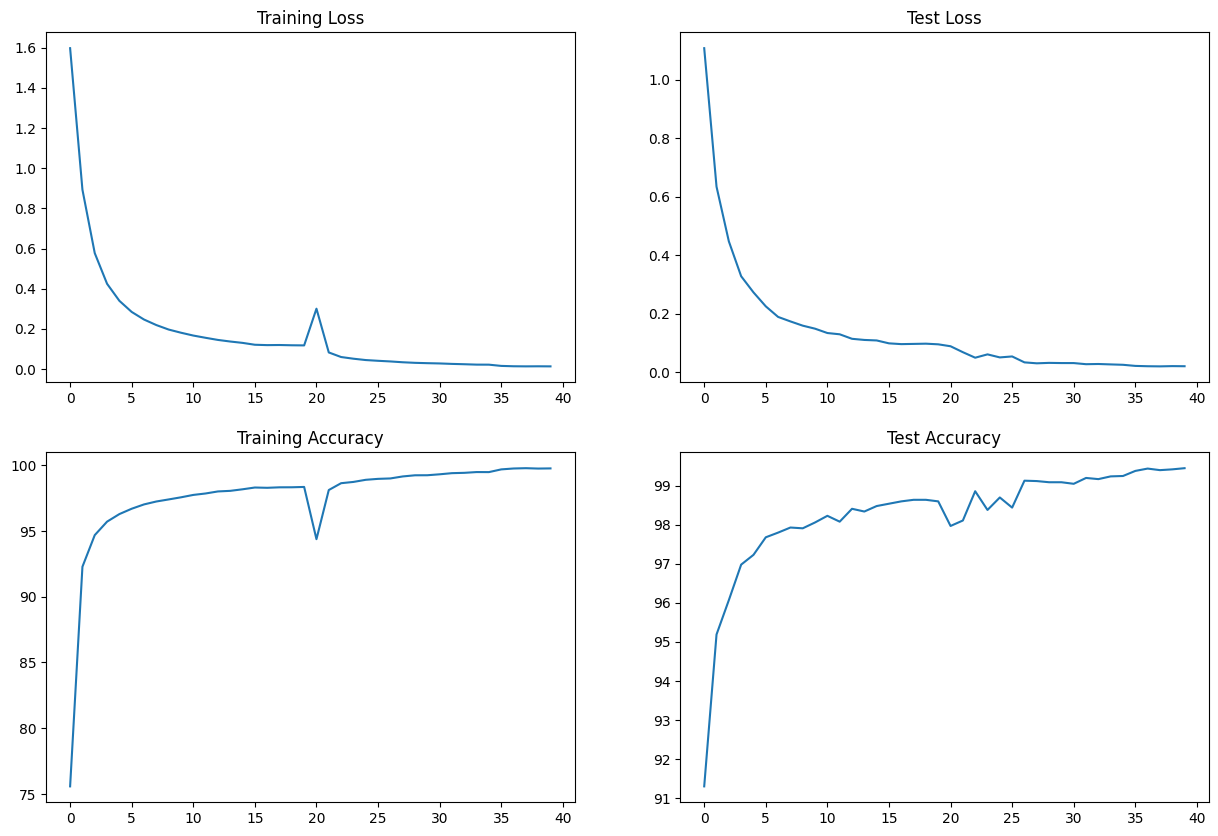

In [19]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")